<a href="https://colab.research.google.com/github/williamfrankholland/MMAI-Deep-Learning/blob/main/colab/Waste_Classification_ResNet_Bill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install focal-loss

import pandas as pd
import numpy as np
import glob
import PIL
from PIL import Image

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv3D, Flatten, MaxPooling2D, AveragePooling2D

from sklearn.utils import shuffle
from tensorflow.keras import Model

from sklearn.metrics import classification_report

from focal_loss import SparseCategoricalFocalLoss

SHAPE_SIZE = 180


     |████████████████████████████████| 462 kB 7.3 MB/s 


In [2]:
# Mount the google drive where the images are stored
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Define which directory to access the file from
imdir = '/content/gdrive/MyDrive/MMAI 894 Team Project/data_clean/'

# Load images with a standard size
image_size = (SHAPE_SIZE, SHAPE_SIZE)

# Set up the bacth size for latter processing
batch_size = 32

# Create a data ierator to allow images to be processed in batches avoiding the
# need for all images to be loaded in memory
total_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imdir,
    #label_mode="categorical",
    label_mode="int",
    #validation_split=0.2,
    subset=None,
    seed=1337,
    image_size=image_size,
    #batch_size=batch_size,
    batch_size=None,
    shuffle=False
)




Found 10038 files belonging to 17 classes.


In [6]:
# Check the number of images loaded
print(total_ds)
print(total_ds.cardinality().numpy())

<PrefetchDataset element_spec=(TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
10038


In [7]:
# Function to create a train, val, test split from a data set object (taken from Stack Overflow and modified)
def get_dataset_partitions_tf(ds, ds_size, train_split=0.5, val_split=0.2, test_split=0.3, shuffle=True, shuffle_size=10000, batch_size=32):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        # Note must set reshuffle_each_iteration to False to avoid data leakage
        ds = ds.shuffle(shuffle_size, seed=12, reshuffle_each_iteration = False)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size).batch(batch_size)
    val_ds = ds.skip(train_size).take(val_size).batch(batch_size)
    test_ds = ds.skip(train_size).skip(val_size).batch(batch_size)
    
    return train_ds, val_ds, test_ds

In [8]:
# Get the data set size to calculate the right split
# When batched this is the number of batches not item count
batch_count = total_ds.cardinality().numpy()
print(batch_count)

# Split the data into three parts
train_ds, val_ds, test_ds = get_dataset_partitions_tf(total_ds, batch_count, train_split=0.5, 
                                                      val_split=0.3, test_split=0.2, shuffle=True, shuffle_size=10000, batch_size=batch_size)

# Check that the split worked
print(train_ds.cardinality().numpy())
print(val_ds.cardinality().numpy())
print(test_ds.cardinality().numpy())


10038
157
95
63


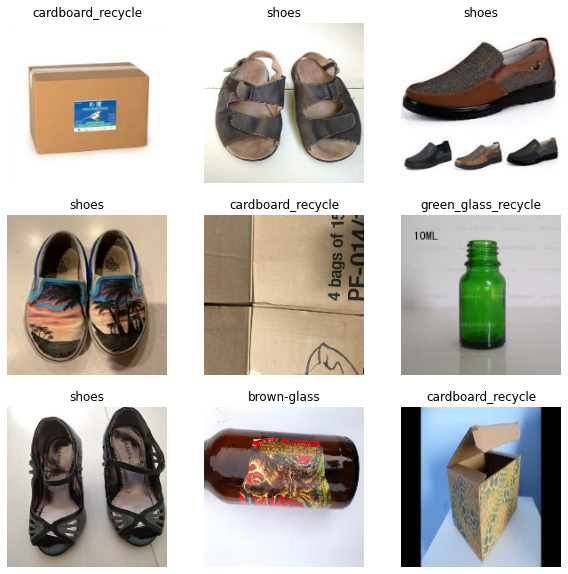

In [9]:
# Get the first batch of 32 then print the first 9 items
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(total_ds.class_names[labels[i]])
        plt.axis("off")

In [73]:
def build_model():


    # Create the base model layers - need to use ResNet50V2
    base_model = keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(SHAPE_SIZE, SHAPE_SIZE, 3))
    base_model.trainable = False

    # Create the input layer with the picture dimention and 3 channels
    input_layer = keras.layers.Input([SHAPE_SIZE, SHAPE_SIZE, 3])

    # Add a small amount of randon translation
    x = keras.layers.RandomTranslation( height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15))(input_layer)
    pre_process = keras.applications.resnet_v2.preprocess_input(x)

    # Add the initial layers to the base model
    x = base_model(pre_process)
    
    # Conv2+ReLU: [5x5, 32] MaxPooling: [2x2]
    x = keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation="relu", name="Conv2d-1", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="Pool-1", padding="same")(x)

    # Conv2+ReLU: [3x3, 64] MaxPooling: [2x2] 
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", name="Conv2d-2", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="Pool-2", padding="same")(x)

    # Conv2+ReLU: [3x3, 256] MaxPooling: [2x2]
    x = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", name="Conv2d-3", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="Pool-3", padding="same")(x)

    # Conv2+ReLU: [3x3, 512] MaxPooling: [2x2]
    x = keras.layers.SeparableConv2D(filters=512, kernel_size=(3, 3), activation="relu", name="Conv2d-5", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same", name="Pool-5", strides=2)(x)
    
    # Flatten out the images before we pass to the dense layers
    x = keras.layers.Flatten()(x)

    # Start with more neurons
    x = keras.layers.Dense(256, activation="relu", name="Denselayer1",)(x)
    # Drop out layer
    x=keras.layers.Dropout(rate=0.35, name="drop_1")(x)

    # Narrow the data size
    x=keras.layers.Dense(128, activation="relu", name="Denselayer2")(x)
    # Drop out layer
    x=keras.layers.Dropout(rate=0.35, name="drop_2")(x)

    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = keras.initializers.GlorotNormal(seed=42)

    #output layer for 17 classes, using softmax activation
    output_layer = Dense(17, 
                    activation='softmax',
                    kernel_initializer=weight_initializer,  
                    kernel_constraint=None,
                    )(x)

    model = Model(input_layer, output_layer)
    model.summary()

    return model

def compile_model(model):

    model.compile(
        # Use focal loss to help train small categories
        loss=SparseCategoricalFocalLoss(gamma=2),
        #loss=keras.losses.sparse_categorical_crossentropy,

        #use Adam gradient descent optimizer
        optimizer=keras.optimizers.Adam(1e-3),
       
        #use accuracy as a metric
        metrics=['accuracy']
    )

    return model

def train_model(model, train, val, epochs = 20):

    # Class weights were not effective in training
    my_class_weight = {
            0: 1.0,
            1: 1.0,
            2: 2.0,
            3: 1.0,
            4: 140.0,
            5: 1.0,
            6: 10.0,
            7: 50.0,
            8: 2.0,
            9: 2.0,
            10: 1.0,
            11: 2.0,
            12: 1.0,
            13: 2.0,
            14: 9.0,
            15: 2.0,
            16: 40.0,
            }

    # Prevent an overfit by stopping early
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    #fit model with train data
    history = model.fit(
        train,
    
        #use 128 batch size, 12 epochs
        batch_size = 128,
        epochs = epochs,
        
        #class_weight=my_class_weight,

        #verbose training, including validation data
        verbose = 2,
        validation_data = val,
        callbacks=[callback]
    )
    return model, history


def eval_model(model, test):

    #evaluate model with test data
    test_loss, test_accuracy = model.evaluate(
        test,
        verbose = 2
    )

    return test_loss, test_accuracy

def tune_model(model, train, val, epochs=5, l_rate=5e-5):
    # Unfreeze the base model
    model.trainable = True

    # Small learning rate to prevent over fitting
    model.compile( 
                  keras.optimizers.Adam(learning_rate=l_rate),
                  #loss=keras.losses.sparse_categorical_crossentropy,
                  loss=SparseCategoricalFocalLoss(gamma=2),
                  metrics=['accuracy'])

    train_model(model, train, val, epochs = epochs)
    return model

In [74]:
model = build_model()
model = compile_model(model)
model, history = train_model(model, train_ds, val_ds)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 random_translation_18 (Rand  (None, 180, 180, 3)      0         
 omTranslation)                                                  
                                                                 
 tf.math.truediv_18 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_18 (TFOpLa  (None, 180, 180, 3)      0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 6, 6, 2048)        23564800  
                                                          

In [75]:
# Now fine tune the model with a small learning rate
l_rate=5e-5
model = tune_model(model, train_ds, val_ds, epochs=10, l_rate=l_rate)
test_loss, test_accuracy = eval_model(model, test_ds)


Epoch 1/10
157/157 - 56s - loss: 0.3068 - accuracy: 0.8805 - val_loss: 0.2667 - val_accuracy: 0.8914 - 56s/epoch - 359ms/step
Epoch 2/10
157/157 - 48s - loss: 0.1338 - accuracy: 0.9291 - val_loss: 0.2263 - val_accuracy: 0.8987 - 48s/epoch - 305ms/step
Epoch 3/10
157/157 - 48s - loss: 0.0808 - accuracy: 0.9560 - val_loss: 0.2410 - val_accuracy: 0.8921 - 48s/epoch - 306ms/step
Epoch 4/10
157/157 - 48s - loss: 0.0664 - accuracy: 0.9576 - val_loss: 0.2187 - val_accuracy: 0.8994 - 48s/epoch - 306ms/step
Epoch 5/10
157/157 - 48s - loss: 0.0529 - accuracy: 0.9643 - val_loss: 0.2163 - val_accuracy: 0.9103 - 48s/epoch - 306ms/step
Epoch 6/10
157/157 - 48s - loss: 0.0472 - accuracy: 0.9687 - val_loss: 0.2275 - val_accuracy: 0.9037 - 48s/epoch - 305ms/step
Epoch 7/10
157/157 - 48s - loss: 0.0441 - accuracy: 0.9715 - val_loss: 0.2038 - val_accuracy: 0.9107 - 48s/epoch - 306ms/step
Epoch 8/10
157/157 - 48s - loss: 0.0412 - accuracy: 0.9727 - val_loss: 0.2308 - val_accuracy: 0.9120 - 48s/epoch - 306

In [61]:
print(total_ds.class_names)

['battery', 'biological', 'brown-glass', 'cardboard_recycle', 'cardboard_trash', 'clothes_donate', 'clothes_garbage', 'green_glass_broken', 'green_glass_recycle', 'metal_recycle', 'paper_recycle', 'plastic_recycle', 'shoes', 'trash', 'trash_toxic', 'white-glass', 'white-glass_broken']


In [62]:
# Extract the labels from the test data set
Y_test_class = tf.concat([labels for images, labels in test_ds], axis=0)

In [63]:
from tensorflow.keras.backend import argmax

# Pass the test set directly to the predict function argmax finds the highest probability
Y_pred_class = argmax(model.predict(test_ds))


In [64]:
# Look at the lables in predict and test
print(np.unique(Y_pred_class))
print(np.unique(Y_test_class))

# Make sure the first 20 look reasonable
print(Y_pred_class[0:20])
print(Y_test_class[0:20])

[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
tf.Tensor([10 12 10  8  0 11 12 12  8 12 13 12  3  8  8  1  0  3 12  0], shape=(20,), dtype=int64)
tf.Tensor([10 12  9  8  0 11  1 12  8 12 13 12  3  8  2  1  0  5 12  0], shape=(20,), dtype=int32)


In [65]:
# Import Seaborn libraries

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setting default fig size
size_ = (10,8)

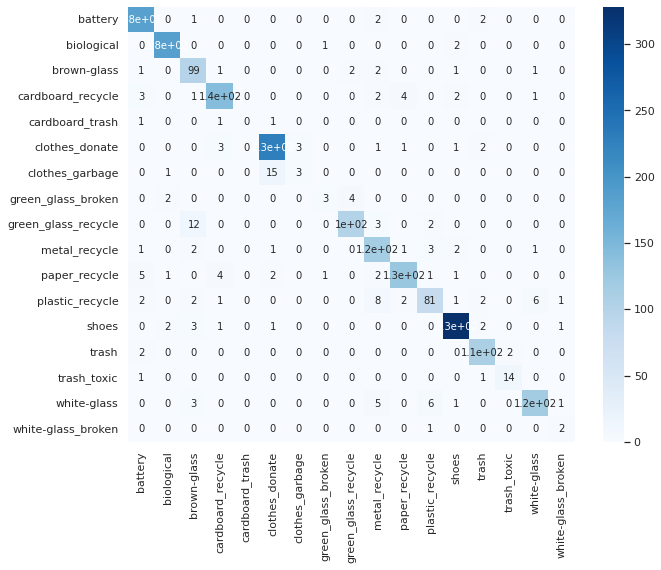

In [66]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix from the test results
cm=confusion_matrix(Y_test_class,Y_pred_class, labels = list(np.arange(17)) ) # normalize='all'
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = total_ds.class_names # ['battery','biological','brown-glass','cardboard_recycle','clothes_donate','clothes_garbage','green_glass_broken','green_glass_recycle','metal_recycle','paper_recycle','plastic_recycle','shoes','trash','trash_toxic','white-glass','white-glass_broken']
df_cm.index = total_ds.class_names # ['battery','biological','brown-glass','cardboard_recycle','clothes_donate','clothes_garbage','green_glass_broken','green_glass_recycle','metal_recycle','paper_recycle','plastic_recycle','shoes','trash','trash_toxic','white-glass','white-glass_broken']

# Plot the confusion matrix as a heat map
fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues") # font size viridis
plt.show()

In [67]:
# Map the multiple buckets into higher level categories
waste_map = {
    #green bin = 0, blue bin = 1, black bin = 2, hazardous waste = 3, donate = 4
    0 : 3,  #battery = 0 ->             3
    1 : 0,  #biological = 1 ->          0
    2 : 1,   #brown glass = 2 ->        1
    3 : 1,  #cardboard recycle = 3 ->   1
    4 : 2,  #cardbard garbage = 4 ->    2
    5 : 4,  #clothes donate = 5 ->      4
    6 : 2,  #clothes garbage = 6 ->     2
    7 : 2,  #green glass broken = 7 ->  2
    8 : 1,  #green glass recycle = 8 -> 1
    9 : 1,  #metal recycle = 9 ->       1
    10 : 1, #paper recycle = 10 ->      1
    11 : 1, #plastic recycle = 11 ->    1
    12 : 4, #shoes = 12 ->              4
    13 : 2, #trash = 13 ->              2
    14 : 3, #trash toxic = 14 ->        3
    15 : 1, #white glass = 15 ->        1
    16 : 2, #white glas broken = 16 ->  2
}
waste_labels = np.unique(list(waste_map.values()))
waste_labels

array([0, 1, 2, 3, 4])

In [68]:
# Map the 17 categories to the 5 high level values using the dictionary
def waste_classify(labels):
  y = np.copy(labels)
  for i in range(17):
    y = np.where(y == i, waste_map[i], y)
  return y

# Map the 17 categories to the 5 high level values
Y_waste_class_pred = waste_classify(Y_pred_class)
Y_waste_class_test = waste_classify(Y_test_class)

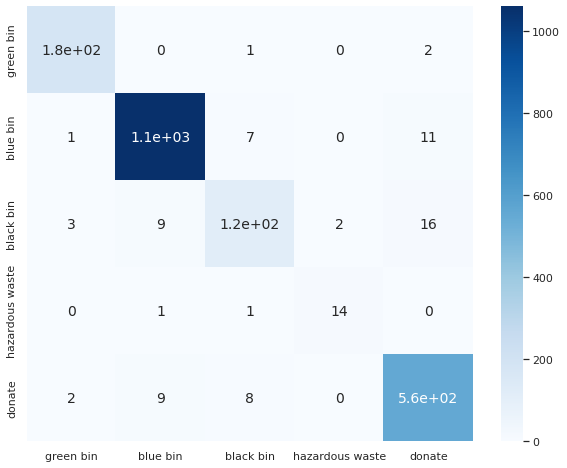

In [69]:
# Calculate the confusion matrix from the test results
cm=confusion_matrix(Y_waste_class_test,Y_waste_class_pred, labels = waste_labels ) # normalize='all'
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = ['green bin','blue bin','black bin','hazardous waste','donate']
df_cm.index = ['green bin','blue bin','black bin','hazardous waste','donate']

# Plot the confusion matrix as a heat map
fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 14}, cmap="Blues") # font size viridis
plt.show()

In [70]:
# Review the statistics for the run
print(classification_report(Y_waste_class_test,Y_waste_class_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       187
           1       0.98      0.98      0.98      1080
           2       0.87      0.80      0.83       147
           3       0.88      0.88      0.88        16
           4       0.95      0.97      0.96       578

    accuracy                           0.96      2008
   macro avg       0.93      0.92      0.93      2008
weighted avg       0.96      0.96      0.96      2008



In [57]:
# Establish a baseline run with no additional layers to gauge performance.

# Create the base model layers
base_model = keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(SHAPE_SIZE, SHAPE_SIZE, 3))
base_model.trainable = False

#print(type(base_model))

input_layer = keras.layers.Input([SHAPE_SIZE, SHAPE_SIZE, 3])
x = keras.layers.RandomTranslation( height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15))(input_layer)
pre_process = keras.applications.resnet_v2.preprocess_input(x)

#print(type(pre_process))

x = base_model(pre_process)

x = keras.layers.Flatten()(x)

output_layer = Dense(17,
                    activation='softmax',
                    #kernel_initializer=weight_initializer,  
                    kernel_constraint=None,
                    )(x)

model = Model(input_layer, output_layer)
model.summary()

model.compile(
       #use catgorical crossentropy loss
       loss=keras.losses.sparse_categorical_crossentropy,
       #use Adam gradient descent optimizer
       optimizer=keras.optimizers.Adam(1e-3),
       
       #use accuracy as a metric
       metrics=['accuracy']
    )

model, history = train_model(model, train_ds, val = val_ds, epochs=20)
# Create an empty model

# Add the pretrained model
#model.add(base_model)
# Freeze the base_model

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 random_translation_16 (Rand  (None, 180, 180, 3)      0         
 omTranslation)                                                  
                                                                 
 tf.math.truediv_16 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_16 (TFOpLa  (None, 180, 180, 3)      0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 6, 6, 2048)        23564800  
                                                          

In [72]:
#pd.DataFrame(Y_train_class).value_counts()